In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install transformers lightning

## Data Paths and Data Loading

In [3]:
from typing import List, Tuple, Callable, Sequence, Union, Dict

import torch
import transformers
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from os.path import join

# Replace with your path
HOME_PATH = '/gdrive/MyDrive/DictateMD_takehome'
DATA_PATH = join(HOME_PATH, 'data')
CSV_FILE_PATH = join(DATA_PATH, 'mtsamples.csv')

In [5]:
# Load data
import pandas as pd
df = pd.read_csv(CSV_FILE_PATH, index_col=0)

In [6]:
# Drop whitespace
df["medical_specialty"] = df["medical_specialty"].map(lambda x: x.strip())

In [7]:
# Reasonable delineation of what are notes and not subspecialties
NOTE_TYPES = [
    "Consult - History and Phy.",
    "SOAP / Chart / Progress Notes",
    "Discharge Summary",
    "Emergency Room Reports",
    "Office Notes",
    "IME-QME-Work Comp etc.",
    "Letters",
    "Autopsy",
]
# Drop columns with invalid subspecialties
df = df[~df['medical_specialty'].isin(NOTE_TYPES)].reset_index(drop=True)

In [8]:
# Identify Nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036 entries, 0 to 4035
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4036 non-null   object
 1   medical_specialty  4036 non-null   object
 2   sample_name        4036 non-null   object
 3   transcription      4004 non-null   object
 4   keywords           3378 non-null   object
dtypes: object(5)
memory usage: 157.8+ KB


In [9]:
# Replace Nulls with empty srings
df = df.fillna('')

In [10]:
# Function to concatenate and delinate different string parts
def construct_input_string(example: str) -> str:
  res = f'''
  Description: {example.description}
  Sample Name: {example.sample_name}
  Transcription: {example.transcription}
  Keywords: {example.keywords}
  '''
  return res

df['input_string'] = df.apply(construct_input_string, axis=1)

## Tokenization + Modeling

In [11]:
# We're going to use Longformer, which is optimized for long sequence lengths
# https://huggingface.co/docs/transformers/model_doc/longformer
from transformers import AutoTokenizer
LONGFORMER_TOKENIZER = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

In [12]:
sequence_lengths = df["transcription"].apply(lambda x: len(LONGFORMER_TOKENIZER(x)["input_ids"]))

Median: 640.00
Mean: 721.65
Min: 2
Max: 4002
Median: 640.0


Text(0.5, 0, 'Sequence Length')

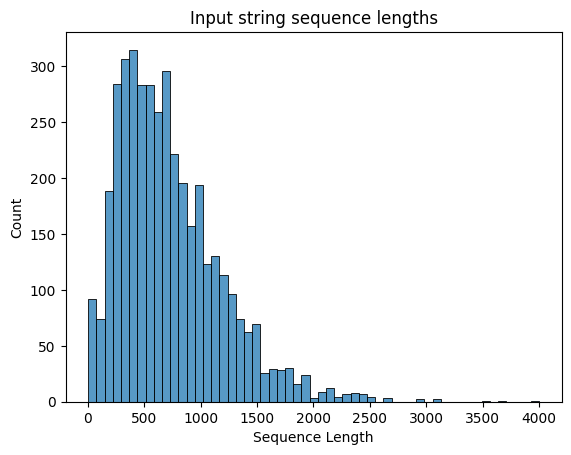

In [13]:
# Plot sequence lengths of concatenated strings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

median = np.median(sequence_lengths)
mean = np.mean(sequence_lengths)
min = np.amin(sequence_lengths)
max = np.amax(sequence_lengths)

print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Min: {min}")
print(f"Max: {max}")
print(f"Median: {median}")

sns.histplot(x=sequence_lengths)
plt.title("Input string sequence lengths")
plt.xlabel("Sequence Length")

In [14]:
# Define Tokenizer that can process almost all strings without truncating
from functools import partial
LONGFORMER_TOKENIZER_FUNC = partial(
    LONGFORMER_TOKENIZER.__call__,
    return_tensors='pt',
    padding='max_length',
    truncation=True,
    max_length=2048
)

In [15]:
from transformers import AutoModelForSequenceClassification

# Load the pretrained Longformer model, class labels, and torch device
NUM_LABELS = len(df['medical_specialty'].unique())
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LONGFORMER_MODEL = AutoModelForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=NUM_LABELS,
).to(DEVICE)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from typing import List, Callable
from torch.utils.data import Dataset, DataLoader

# Define Label Mappings
SPECIALTIES_SORTED = sorted(df['medical_specialty'].unique())
SPECIALTY_TO_ID_MAP = dict(zip(SPECIALTIES_SORTED, range(len(SPECIALTIES_SORTED))))
ID_TO_SPECIALTY_MAP = {v: k for k, v in SPECIALTY_TO_ID_MAP.items()}

# PyTorch datasets for loading / training
class TextDataset(Dataset):
  '''Tokenizes inputs, used for inference'''
  def __init__(
      self,
      text_list: List[str],
      tokenizer_func: Callable[[str | List[str]], torch.Tensor]
    ):
    self.text_list = text_list
    self.tokenizer_func = tokenizer_func

  def __len__(self):
    return len(self.text_list)

  def collate_fn(self, batches):
    return torch.cat(batches, dim=0)

  def __getitem__(self, idx):
    # Return only the input
    text_batch = self.text_list[idx]
    return self.tokenizer_func(text_batch).input_ids


class TextDatasetWithLabels(TextDataset):
  '''Tokenizes inputs and includes ground truth, meant for training.'''
  def __init__(
      self,
      text_list: List[str],
      tokenizer_func: Callable[[str | List[str]], torch.Tensor],
      specialties: List[str]
  ):
    super().__init__(text_list, tokenizer_func)
    # Encode label with ID for every specialty string
    self.encoded_labels = [SPECIALTY_TO_ID_MAP[specialty] for specialty in specialties]

  def collate_fn(self, batches: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    # Collates lists of tuples into a tuple of tensors
    input_ids = torch.cat([item[0] for item in batches], dim=0)
    encoded_labels = torch.cat([item[1] for item in batches], dim=0)

    return input_ids, encoded_labels

  def __getitem__(self, idx: Union[int, slice]) -> torch.Tensor:
    # Return both inputs and labels
    input_ids_batch = super().__getitem__(idx)
    encoded_labels_batch = self.encoded_labels[idx]
    if isinstance(encoded_labels_batch, int):
      encoded_labels_batch = torch.tensor([encoded_labels_batch], dtype=torch.long)
    else:
      encoded_labels_batch = torch.tensor(encoded_labels_batch, dtype=torch.long)

    return input_ids_batch, encoded_labels_batch

### Define Model

In [17]:
# Use PyTorch Lightning, simplifies training, validation, optimization, etc.
from typing import Tuple

import torch.nn as nn
import torch.optim as optim

class LitMedicalClassificationModel(pl.LightningModule):
  def __init__(
      self,
      num_labels: int,
      classifier: AutoModelForSequenceClassification,
      loss_module: nn.Module,
      learning_rate: float = 2e-5,
      weight_decay: float = 0.1
  ):
    '''Lightning Module that defines classifier, hyperparams, loss.'''
    super().__init__()
    self.classifier = classifier
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
    self.loss_module = loss_module

    self.train_losses = []
    self.valid_losses = []

  def _step(
      self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int, losses: List[int]
  ) -> torch.Tensor:
    """Generic function for doing either a training or validation step"""
    input_ids, labels = batch
    logits = self(input_ids)
    loss = self.loss_module(logits, labels)
    losses.append(loss.cpu().detach().item())
    return loss

  def configure_optimizers(self) -> torch.optim.Optimizer:
    # Use AdamW optimizer, standard for training neural networks
    return torch.optim.AdamW(
      self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
    )

  def training_step(
      self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
  ) -> torch.Tensor:
    train_loss = self._step(batch, batch_idx, self.train_losses)
    self.log("train_loss", train_loss, prog_bar=True)
    return train_loss

  def validation_step(
    self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
  ) -> torch.Tensor:
    valid_loss = self._step(batch, batch_idx, self.valid_losses)
    self.log("valid_loss", valid_loss, prog_bar=True)
    return valid_loss

  def forward(self, input_ids: torch.Tensor):
    return self.classifier(input_ids=input_ids).logits


In [18]:
from torch.utils.data import DataLoader

# Helper functions to create datasets and dataloaders
def make_dataset(
    df: pd.DataFrame,
    tokenizer_func: Callable[[str | List[str]], torch.Tensor],
    with_labels: bool = True
  ) -> TextDataset:
  input_strings = df["input_string"].tolist()
  if with_labels:
    # if specified, include ground truth labels
    medical_specialties = df["medical_specialty"].tolist()
    return TextDatasetWithLabels(
        input_strings,
        tokenizer_func,
        medical_specialties
    )
  else:
    return TextDataset(input_strings, tokenizer_func)

def make_dataloader(
    df: pd.DataFrame,
    tokenizer_func: Callable[[str | List[str]], torch.Tensor],
    with_labels: bool = True,
    shuffle: bool = True,
    batch_size: int = 32,
    num_workers: int = 2
) -> DataLoader:
  dataset = make_dataset(df, tokenizer_func, with_labels=with_labels)

  # Create dataloader, specify batch size, num workers, shuffling
  return DataLoader(
      dataset,
      batch_size=batch_size,
      num_workers=num_workers,
      collate_fn=dataset.collate_fn,
      shuffle=shuffle
  )


In [19]:
import os
import random

# set seed so we can reproduce results
def seed_everything(seed: int):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True

seed_everything(42)

In [20]:
from sklearn.model_selection import train_test_split


# define validation split
TEST_SIZE = 0.2

# batch size and workers for training + validation
BATCH_SIZE = 4
NUM_WORKERS = 2

TRAIN_DF, VALID_DF = train_test_split(df, test_size=TEST_SIZE)
TRAIN_DATALOADER_WITH_LABELS = make_dataloader(
    TRAIN_DF,
    LONGFORMER_TOKENIZER_FUNC,
    with_labels=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

VALID_DATALOADER_WITH_LABELS = make_dataloader(
    VALID_DF,
    LONGFORMER_TOKENIZER_FUNC,
    with_labels=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

# We're going to use class weighting in the loss function.
# Based on the class distribution of the entire dataset.
# This helps mitigate class imbalance

def compute_class_weight_tensor(
    subspecialties: List[str], classes: Sequence[int]
  ) -> torch.Tensor:
  """
  Helper function to compute a class weight tensor based on the class
  distribution. This is meant to be passed into the `weight` parameter in
  the PyTorch loss module
  """
  encoded_labels = [
      SPECIALTY_TO_ID_MAP[specialty] for specialty in subspecialties
  ]
  class_weight = torch.Tensor(compute_class_weight(
      class_weight="balanced",
      classes=classes,
      y=encoded_labels
  ))
  return class_weight

CLASS_WEIGHT_TENSOR = compute_class_weight_tensor(
    df["medical_specialty"].tolist(),
    np.arange(len(df["medical_specialty"].unique()))
).to(DEVICE)

## Model Training

In [22]:
# Make directories for model checkpointing
CKPT_DIR = join(HOME_PATH, 'checkpoints')
os.makedirs(CKPT_DIR, exist_ok=True)

# Define Cross Entropy Loss function and model kwargs
LOSS_MODULE = nn.CrossEntropyLoss(weight=CLASS_WEIGHT_TENSOR)
MODEL_KWARGS = {
    'num_labels': NUM_LABELS,
    'classifier': LONGFORMER_MODEL,
    'loss_module': LOSS_MODULE,
    'learning_rate': 2e-5,
    'weight_decay': 0.1
}

# Optionally load from a checkpoint
CKPT_FILENAME = 'medical-model-epoch=3-train_loss=0.07-valid_loss=0.46.ckpt'
CKPT_PATH = join(CKPT_DIR, CKPT_FILENAME)
if CKPT_PATH is not None:
  LIT_MODEL = LitMedicalClassificationModel.load_from_checkpoint(
      checkpoint_path=CKPT_PATH,
      **MODEL_KWARGS
  )
else:
  LIT_MODEL = LitMedicalClassificationModel(**MODEL_KWARGS)

In [23]:
# Define a callback to save checkpoints every 2 epochs
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=CKPT_DIR,
    filename='medical-model-{epoch}-{train_loss:.2f}-{valid_loss:.2f}',
    every_n_epochs=2,
    save_top_k=-1
)

# Define the Lightning Trainer
# Use mixed precision training, and gradient accumulation to account for small batches
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=5,
    default_root_dir=CKPT_DIR,
    callbacks=[checkpoint_callback],
    accumulate_grad_batches=4,
    precision=16
)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
TRAIN = False
if TRAIN:
  trainer.fit(
      model=LIT_MODEL,
      train_dataloaders=TRAIN_DATALOADER_WITH_LABELS,
      val_dataloaders=VALID_DATALOADER_WITH_LABELS
  )

In [25]:
import pickle

def save_object(obj, path):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def load_object(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)

  return obj

def save_or_load(path, obj=None):
  if os.path.exists(path):
    return load_object(path)
  else:
    save_object(obj, path)
    return obj


TRAIN_LOSSES_PATH = join(CKPT_DIR, 'train_losses.p')
TRAIN_LOSSES = save_or_load(TRAIN_LOSSES_PATH)
VALID_LOSSES_PATH = join(CKPT_DIR, 'valid_losses.p')
VALID_LOSSES = save_or_load(VALID_LOSSES_PATH)

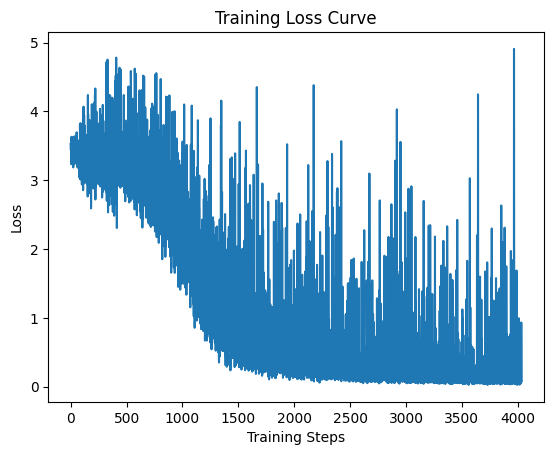

In [26]:
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.plot(np.arange(len(TRAIN_LOSSES)), TRAIN_LOSSES)

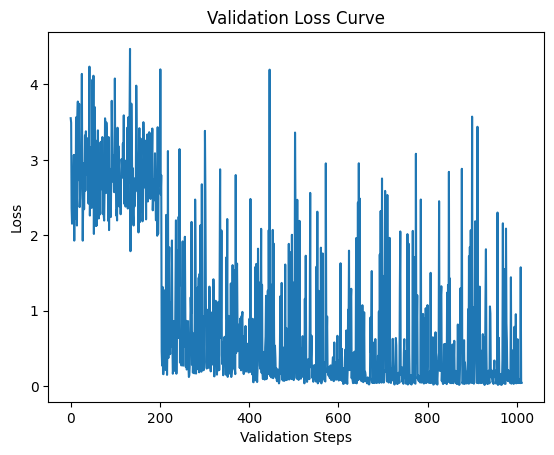

In [27]:
plt.title("Validation Loss Curve")
plt.xlabel("Validation Steps")
plt.ylabel("Loss")
plt.plot(np.arange(len(VALID_LOSSES)), VALID_LOSSES)

In [28]:
from tqdm import tqdm

def predict_proba(
    model: pl.LightningModule,
    df: pd.DataFrame,
    tokenizer_func: Callable[[str | List[str]], torch.Tensor],
    batch_size: int = 32,
    num_workers: int = 4,
    device: torch.device =torch.device("cuda:0")
  ) -> torch.Tensor:
    """
    Multiclass predict probabilities function that.
    We create this as a non-class method so we don't have to continually account
    for what device the module is on within the class itself
    """
    if model.device != device:
      model = model.to(device)

    model.eval()
    dataloader = make_dataloader(
        df,
        tokenizer_func,
        with_labels=False,
        shuffle=False,
        batch_size=batch_size,
        num_workers=num_workers
    )
    pred_probs_list = []
    for input_ids_batch in tqdm(dataloader):
      input_ids_batch = input_ids_batch.to(device)
      with torch.no_grad():
        logits_batch = model(input_ids_batch)
      pred_probs_batch = nn.Softmax(dim=1)(logits_batch)
      pred_probs_list.append(pred_probs_batch.detach().cpu())

    pred_probs = torch.cat(pred_probs_list, dim=0)
    return pred_probs

## Evaluation

In [29]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score
)

class ModelEvaluation:
  """
  Simple class that does model evaluation and allows access to attributes
  """
  def __init__(
      self,
      model: pl.LightningModule,
      train_df: pd.DataFrame,
      valid_df: pd.DataFrame,
      tokenizer_func: Callable[[str | List[str]], torch.Tensor],
      label_map: Dict[str, int]
    ):
    self.model = model
    self.train_df = train_df
    self.valid_df = valid_df
    self.tokenizer_func = tokenizer_func
    self.label_map = label_map

    self._set_predictions()
    self._set_metrics()

  def _set_predictions(self):
      #Set probs / predictions / ground truth on train + validation
      self.train_probs = predict_proba(
          self.model,
          self.train_df,
          self.tokenizer_func
      )
      self.train_preds = self.train_probs.argmax(dim=1)
      self.train_labels = torch.Tensor(
          [self.label_map[category] for category in self.train_df["medical_specialty"]]
      ).long()
      self.valid_probs = predict_proba(
          self.model,
          self.valid_df,
          self.tokenizer_func
      )
      self.valid_preds = self.valid_probs.argmax(dim=1)
      self.valid_labels = torch.Tensor(
          [self.label_map[category] for category in self.valid_df["medical_specialty"]]
      ).long()

      self.num_labels = len(self.label_map)
      self.display_labels = list(self.label_map.keys())

  def _set_metrics(self):
    # Confusion matrices + displays for training + validation
    self.cm_train = confusion_matrix(
        self.train_labels,
        self.train_preds,
        labels=np.arange(self.num_labels)
    )
    self.cm_train_display = ConfusionMatrixDisplay(
        confusion_matrix=self.cm_train,
        display_labels=self.display_labels
      )

    self.cm_valid = confusion_matrix(
        self.valid_labels,
        self.valid_preds,
        labels=np.arange(self.num_labels)
    )
    self.cm_valid_display = ConfusionMatrixDisplay(
        confusion_matrix=self.cm_valid,
        display_labels=self.display_labels
    )

    # Class reports for training + validation
    self.train_class_report = classification_report(
        y_true=self.train_labels,
        y_pred=self.train_preds,
        labels=np.arange(self.num_labels),
        target_names=self.display_labels
    )

    self.valid_class_report = classification_report(
        y_true=self.valid_labels,
        y_pred=self.valid_preds,
        labels=np.arange(self.num_labels),
        target_names=self.display_labels
      )


In [32]:
MODEL_EVAL_PATH = join(CKPT_DIR, 'model_eval.p')
if os.path.exists(MODEL_EVAL_PATH):
  model_evaluation = save_or_load(MODEL_EVAL_PATH)
else:
  model_evaluation = ModelEvaluation(
      model=LIT_MODEL,
      train_df=TRAIN_DF,
      valid_df=VALID_DF,
      tokenizer_func=LONGFORMER_TOKENIZER_FUNC,
      label_map=SPECIALTY_TO_ID_MAP
  )

In [33]:
# Training Classification report
print(model_evaluation.train_class_report)

                            precision    recall  f1-score   support

      Allergy / Immunology       1.00      0.50      0.67         4
                Bariatrics       0.93      1.00      0.97        14
Cardiovascular / Pulmonary       0.93      0.95      0.94       298
              Chiropractic       0.60      0.86      0.71        14
Cosmetic / Plastic Surgery       0.83      1.00      0.91        20
                 Dentistry       0.92      1.00      0.96        22
               Dermatology       1.00      1.00      1.00        22
      Diets and Nutritions       0.90      1.00      0.95         9
      ENT - Otolaryngology       0.91      0.96      0.94        76
             Endocrinology       0.75      1.00      0.86        15
          Gastroenterology       0.95      0.97      0.96       189
          General Medicine       0.94      0.91      0.92       215
     Hematology - Oncology       0.85      0.96      0.90        69
 Hospice - Palliative Care       1.00      0.80

In [34]:
# Validation Classification report
print(model_evaluation.valid_class_report)

                            precision    recall  f1-score   support

      Allergy / Immunology       1.00      0.33      0.50         3
                Bariatrics       0.80      1.00      0.89         4
Cardiovascular / Pulmonary       0.90      0.95      0.92        74
              Chiropractic       0.00      0.00      0.00         0
Cosmetic / Plastic Surgery       0.70      1.00      0.82         7
                 Dentistry       0.83      1.00      0.91         5
               Dermatology       0.86      0.86      0.86         7
      Diets and Nutritions       1.00      1.00      1.00         1
      ENT - Otolaryngology       0.88      0.95      0.91        22
             Endocrinology       0.75      0.75      0.75         4
          Gastroenterology       0.91      0.98      0.94        41
          General Medicine       0.80      0.75      0.78        44
     Hematology - Oncology       0.86      0.90      0.88        21
 Hospice - Palliative Care       1.00      1.00

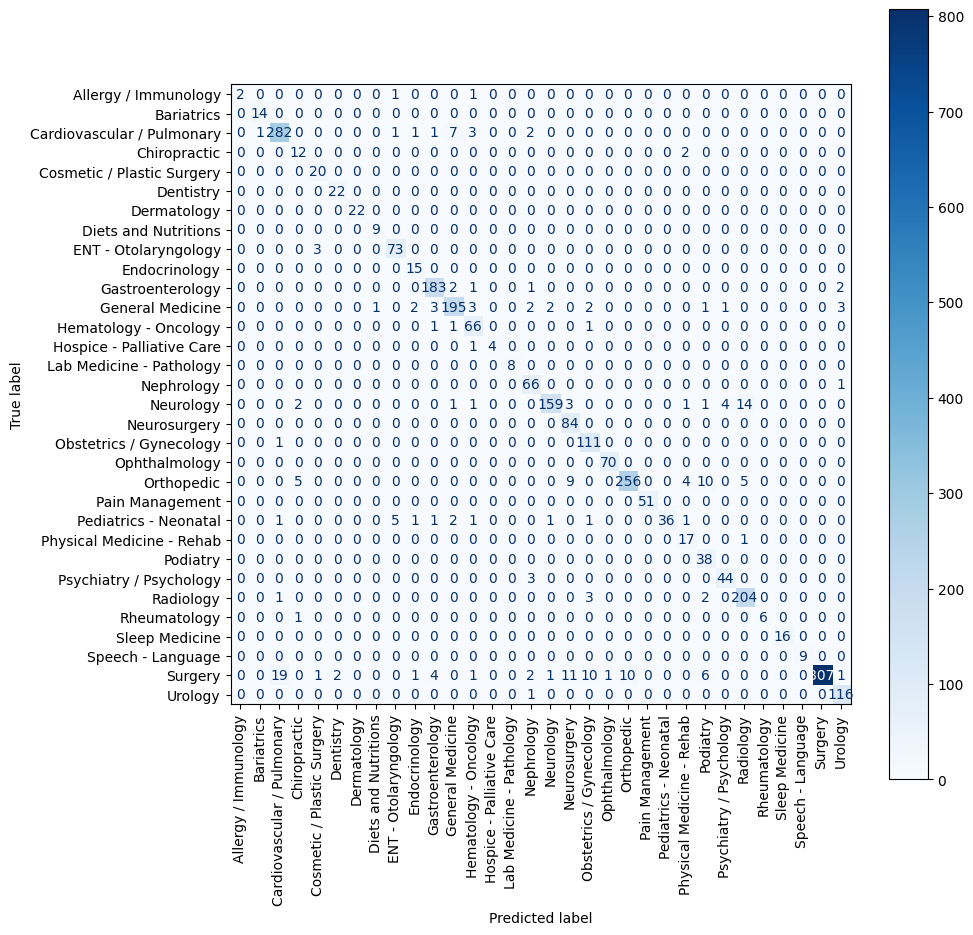

In [35]:
# Training confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # You can change the size as needed
model_evaluation.cm_train_display.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()

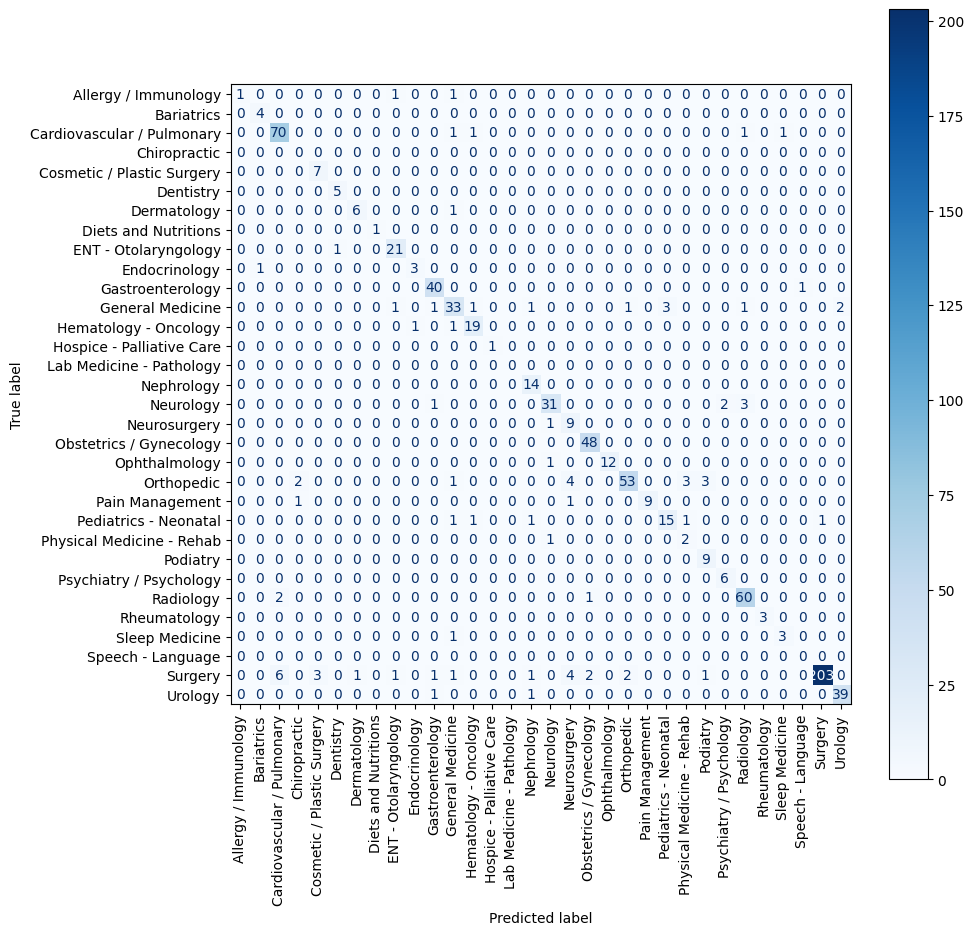

In [36]:
# Validation confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # You can change the size as needed
model_evaluation.cm_valid_display.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()